https://www.youtube.com/watch?v=QyW28ZJv7lg

In [30]:
import scipy
from scipy import optimize
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt,rcParams
from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm
import patsy

realmin = np.finfo(np.double).tiny

#Some plotting specs.
plt.style.use('fast')
rcParams['axes.grid']=False
rcParams['font.size'] = 20
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False

In [2]:
# #Remove some of the data, and clean it up.
# floc = '~//Code//python//datasync_10-04//'
# fname = 'reversal_data.csv'
# data = pd.read_csv(floc+fname)

# #clean and reformat data

# data['greenProb'] = data['greenProb']/100
# data['redProb'] = data['redProb']/100
# data['choseRed'] = ((data['choseRed']==2) | (data['choseRed']==4))+0

# #get subset of data
# nsess = 72
# animalId = 2
# relevant_columns = ['animal','sessionNum','trialNum','volatility','rewarded','choseRed','greenProb','redProb','greenMag','redMag']
# data_subset = data.loc[(data['sessionNum']<=nsess) & (data['animal']==animalId)][relevant_columns]

# data_subset = data_subset.loc[data_subset['volatility']==1]

# data_subset = data_subset[['greenProb','redProb','greenMag','redMag','choseRed','rewarded']]
# data_subset.to_csv(floc+'reversal_data_subset.csv',index=False)

In [3]:
#Load in the data
floc = '~//Code//python//datasync_10-04//'
fname = 'reversal_data_subset.csv'
data = pd.read_csv(floc+fname)

# What are we looking at? 

In [4]:
data

,greenProb,redProb,greenMag,redMag,choseRed,rewarded
0,0.8,0.2,4,4,1,0
1,0.8,0.2,2,1,0,0
2,0.8,0.2,4,2,0,0
3,0.8,0.2,4,1,0,1
4,0.8,0.2,2,4,0,1
5,0.8,0.2,1,4,1,0
6,0.8,0.2,1,1,0,1
7,0.8,0.2,1,2,0,1
8,0.8,0.2,1,2,0,1
9,0.8,0.2,4,4,0,1


# Expected value



In [33]:
data['EVRed'] = data['redProb']*data['redMag']
data['EVGreen'] = data['greenProb']*data['greenMag']
data['deltaEV'] = data['EVRed'] - data['EVGreen']

Text(0.5,1,'Xavier')

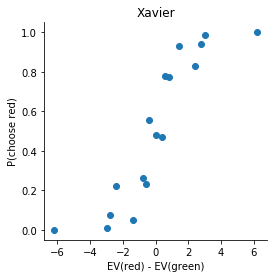

In [6]:
pChooseRed = data.groupby(['deltaEV'])['choseRed'].agg(['mean'])

_,ax = plt.subplots(1,1,figsize=[4,4])
ax.errorbar(pChooseRed.index,pChooseRed['mean'].values,fmt='o')
plt.xlabel('EV(red) - EV(green)')
plt.ylabel('P(choose red)')
plt.title('Xavier')

# Fit a simple model of animal behavior "by hand"

We want a model that transforms the input on a given trial (e.g., probability of reward associated with each option, and magnitude of reward) into a probability of choosing one of the options.

We can break this into two parts: The model that values each of the goods and compares them, and a model that takes the result of the comparison and turns it into a probability. 


In [7]:
#Takes a weighted relative valuation of each option, which in our case will be the difference in 
#the EV of the red and green targets.
choiceModel = lambda x,b: b[0]+b[1]*x

#Converts the weighted relative valuation into a probability of an action.
logistic = lambda x :1./(1.+np.exp(-x))

In [8]:
#Now we want to fit our model. To do this, we'll set up a likelihood function, and then fold
#our three equations together to make a single objective function. We can plug our data
#into the objective function, then run it through an optimization algorithm. 

#This is the standard negative log-bernoulli loss function.
#I've added protection against taking the log of zero
cost = lambda y,h: -np.sum(y*np.log(np.max([h,np.ones(len(h))*realmin],axis=0))+
(1-y)*np.log(np.max([1-h,np.ones(len(h))*realmin],axis=0))); 

#Hook up all of the equations to eachother to make an objective function
objective = lambda x,y,b: cost(y,logistic(choiceModel(x,b)))

#Fit it!
initialGuesses = [1,1] #Normally we should do something like a grid search, but this is a linear model
optimizationOutput = optimize.minimize(lambda b: objective(data['deltaEV'],data['choseRed'],b),initialGuesses)
coefEstimates = optimizationOutput.x

In [11]:
#Did it actually work? Lets use StatsModels to fit a linear model.
#The coefficient estimates should be identical.
y,X = patsy.dmatrices('choseRed ~ deltaEV',data)
linearModel = GLM(
    endog=y,exog=X,family=sm.genmod.families.family.Binomial()
).fit()
coefTruth = linearModel.params

In [12]:
#The coefficient estimates from our model and the StatsModels model should be roughly equal.
print('Manual coef. values: '+str(coefEstimates))
print('Regression coef. values: ' + str(coefTruth))

Manual coef. values: [0.04067677 1.07373477]
Regression coef. values: [0.04067678 1.07373477]


Text(0.5,1,'Xavier')

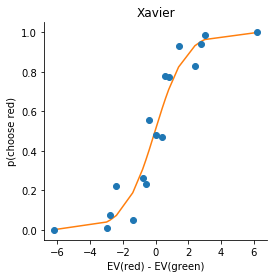

In [27]:
# Lets visualize model performance. How well does it capture choice behavior?

predictions = logistic(choiceModel(pChooseRed.index,coefEstimates))

_,ax = plt.subplots(1,1,figsize=[4,4])
ax.errorbar(pChooseRed.index,pChooseRed['mean'].values,fmt='o')
ax.plot(pChooseRed.index,predictions)
ax.set_xlabel('EV(red) - EV(green)')
ax.set_ylabel('p(choose red)')
ax.set_title('Xavier')

# A more complicated model: reinforcement learning

The previous model assumes that the animal uses true probabilities to estimate expected value. Actually, the probabilities are changing constantly, and must be estimated in real-time based on the animals' experience.

Further reading:

A book: https://drive.google.com/file/d/1opPSz5AZ_kVa1uWOdOiveNiBFiEOHjkG/view

A paper: http://www.princeton.edu/~ndaw/d10.pdf


In [52]:
#A simple TD learner. This learns the probability that an animal
#is rewarded after selecting the red target or the green target
#
#Because p(reward|chose red) = 1 - p(reward|chose green), we will
#assume that the animal tracks a single probability. 
def temporalDifferenceLearner(choice,outcome,learningRate):
    
    #Our learner's dumb initial estimate of reward probaiblity
    pRed = .5
    pGreen = 1 - pRed
    
    p = np.zeros([len(choice)])
    for i in range(0,len(choice)):
        #Store information about the probability
        p[i] = pRed
        
        #our learner's belief about how likely a reward was this trial
        pReward = choice[i]*pRed + (1-choice[i])*pGreen
        
        #How surprised were we about the outcome (magnitude),
        #and was it a good or bad surprise (sign)?
        rewardPredictionError = outcome[i] - pReward
        
        #Update the learner's belief
        if(choice[i]):#if chose red
            pRed = pReward + learningRate*rewardPredictionError
            pGreen = 1 - pRed
        elif(not choice[i]):
            pGreen = pReward + learningRate*rewardPredictionError
            pRed = 1 - pGreen
        else:
            raise ValueError("Choice was %d on trial %d" % (choice[i],i))
            
    return p
                

Text(0.5,0,'Trial #')

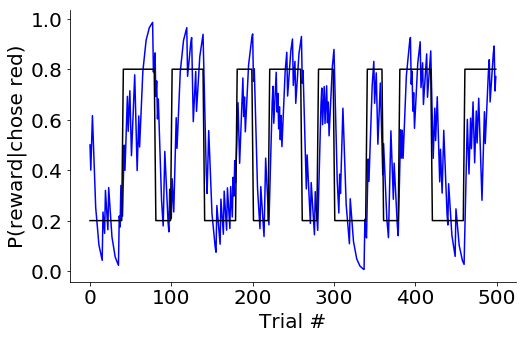

In [53]:
#How well does one of these learners do?
learningRate = .2
learnedPRed = temporalDifferenceLearner(data['choseRed'],data['rewarded'],learningRate)

ntrial = 500
_,ax = plt.subplots(1,1,figsize=[8,5])
ax.plot(data.index[0:ntrial],learnedPRed[0:ntrial],'-b')
ax.plot(data.index[0:ntrial],data['redProb'][0:ntrial],'-k')
ax.set_ylabel('P(reward|chose red)')
ax.set_xlabel('Trial #')

In [60]:
#Lets write a function for learning, then estimating EV
def learnedDeltaEV(data,learningRate):
    learnedPRed = temporalDifferenceLearner(data['choseRed'],data['rewarded'],learningRate)
    estimatedDeltaEV = learnedPRed*data['redMag'] - (1-learnedPRed)*data['greenMag']
    return estimatedDeltaEV

estimatedPChooseRed = lambda x,b: logistic(choiceModel(learnedDeltaEV(x,b[0]),b[1:3]))
objectiveRL = lambda x,y,b: cost(y,estimatedPChooseRed(x,b))

In [61]:
#Fit it!
initialGuessesRL = [.15,.03,1.5] #Normally we should do something like a grid search, but this is a linear model
optimizationOutputRL = optimize.minimize(lambda b: objectiveRL(data,data['choseRed'],b),initialGuessesRL)
paramsRL = optimizationOutputRL.x

Text(0,0.5,'P(choose red)')

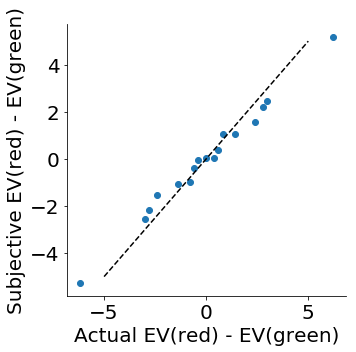

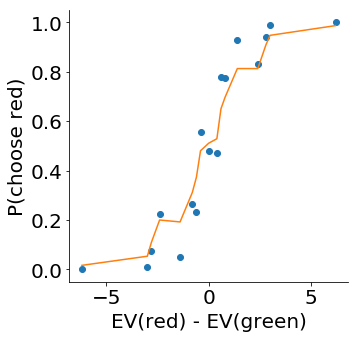

In [72]:
data['estimatedEV'] = learnedDeltaEV(data,paramsRL[0])
data['estimatedPChooseRed'] = estimatedPChooseRed(data,paramsRL)
realVsSubjectiveEV = data.groupby(['deltaEV'])['estimatedEV'].agg(['mean'])

_,ax = plt.subplots(1,1,figsize=[5,5])
ax.scatter(realVsSubjectiveEV.index,realVsSubjectiveEV.values)
ax.plot([-5,5],[-5,5],'--k')
ax.set_xlabel('Actual EV(red) - EV(green)')
ax.set_ylabel('Subjective EV(red) - EV(green)')

pChooseRedRL = data.groupby(['deltaEV'])['estimatedPChooseRed'].agg(['mean'])

_,ax = plt.subplots(1,1,figsize=[5,5])
ax.plot(pChooseRed.index,pChooseRed.values,'o')
ax.plot(pChooseRedRL.index,pChooseRedRL.values)
ax.set_xlabel('EV(red) - EV(green)')
ax.set_ylabel('P(choose red)')